# <b style='color:magenta;'> SVM </b>

* Este Jupyter tem como função treinar um `SVM` com os melhores parametros determinados por um `RandomSearch`.

-> Dataset completo com voluntários femininos, sem outliers e sem a coluna de semanas e com pca.

---

Bibliotecas/Módulos

In [20]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import sys

from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, confusion_matrix, average_precision_score, accuracy_score, matthews_corrcoef, classification_report, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

Configurações dos logs

In [21]:
logger = logging.getLogger("SVM")
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler(sys.stderr)
formatter = logging.Formatter('%(name)s - %(levelname)s - [+] ------- %(message)s -------') 
handler.setFormatter(formatter)
logger.handlers = [handler]

Cores

In [22]:
RED = "\033[1;31m"
BLUE = "\033[1;34m"
GREEN = "\033[1;32m"
PINK = "\033[1;45m"
HEADER = '\033[95m'
OKBLUE = '\033[94m'
OKCYAN = '\033[96m'
OKGREEN = '\033[92m'
WARNING = '\033[93m'
FAIL = '\033[91m'
ENDC = '\033[0m'
BOLD = '\033[1m'
UNDERLINE = '\033[4m'
MAG = "\033[1;45m"

---

## Preparando os dados

In [23]:
df = pd.read_csv("dados_FEM_10_voluntarios_c_semanas_15_sinais_noout.csv")

In [24]:
df.sample()

,0,1,2,3,4,5,6,7,8,9,...,1992,1993,1994,1995,1996,1997,1998,1999,label,semana
6877,3,-3,1,-8,7,-3,8,9,-1,-6,...,15,2,-24,1,26,9,-20,31,0,4


* Seleção da variável target e das features

In [25]:
y = df["semana"]

In [26]:
df = df.drop(["semana"], axis=1)

#### PCA
Aplicando o PCA para reduzir a dimensão dos dados.

In [27]:
pca = PCA(n_components=1000)

In [28]:
pca.fit(df)

PCA(n_components=1000)

In [29]:
%%time

pca_samples = pca.transform(df)

CPU times: user 13.9 s, sys: 0 ns, total: 13.9 s
Wall time: 1.09 s


In [30]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-31.426972,19.593266,66.149497,5.087693,-145.755438,-60.110903,-95.581629,8.489667,-73.231320,-43.579136,...,5.468757,-2.663963,-9.810332,1.662197,11.827076,9.822600,-9.668590,3.400646,5.212768,-24.916429
1,-67.161373,33.442037,43.310118,-14.236839,-144.593542,-12.403398,-98.242895,-2.547335,-69.538878,-37.210569,...,-8.333013,-9.078448,-8.621835,-13.381592,23.525468,-2.658485,1.435818,13.156601,-3.517392,-29.927835
2,-93.019930,35.557195,5.966039,-26.539077,-151.494378,32.550934,-112.608380,-15.639923,-59.108039,-28.130038,...,-14.951405,-18.272953,-6.149932,-19.423299,16.746207,-12.278881,10.489434,18.840943,-9.394554,-34.014346
3,-114.755784,34.779378,-10.552657,-39.481854,-145.625364,72.526742,-111.402247,-35.211066,-48.914545,-12.286798,...,-8.815110,-25.650863,-8.011198,-14.096027,11.708198,-17.276108,14.285039,14.198415,-21.348064,-30.897531
4,-111.867249,44.544022,-26.877515,-47.197607,-135.394425,97.920772,-85.358632,-53.932529,-39.548346,-1.877483,...,-1.287050,-32.338709,0.038467,-7.322151,1.239712,-14.236380,11.628854,16.359986,-23.990178,-18.960287


In [31]:
len(ps)

18000

In [32]:
len(ps.columns)

1000

In [33]:
X = ps

Separando os dados em dados de treino e teste

In [34]:
x_treino, x_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=7)

---

## Treinamento

### SVM

In [35]:
def classificador(x_treino, y_treino, x_teste, y_teste):
    '''
        Treina um classificador com os melhores parametros possíveis.
        
        Params
        ------
        :x_treino: dados de treino
        :x_teste: dados de teste
        :y_treino: dados de treino -labels
        :y_teste: dados de treino - labels
    
        Return
        ------
        :SVM: Modelo SVM treinado
        :resultados (matrix): métricas
    '''
    stats = {}
    
    logger.info('Instanciando SVM')
    SVM = OneVsRestClassifier(SVC(kernel = 'poly', C= 100))
    
    logger.info('Treinando Random Forest')
    SVM.fit(x_treino, y_treino)
    
    logger.info('Predict')
    categorias = SVM.predict(x_teste)
    
    logger.info('Métricas: \n \n')
    
    logger.info('Acurácia')
    acc = accuracy_score(y_teste, categorias)
    print(OKCYAN, "Acc \n" + str(acc) + "\n")
    
    logger.info("Mcc")
    mcc = matthews_corrcoef(y_teste, categorias)
    print(WARNING, "Mcc \n" + str(mcc) + "\n")
    
    logger.info("F1")
    f1 = f1_score(y_teste, categorias, average="weighted")
    print(GREEN, "F1 \n" + str(f1) + "\n")
    
    logger.info('Class Report')
    resultados = classification_report(y_teste, categorias)
    print(ENDC, "Class Report \n" + resultados + "\n")
    
    mat = confusion_matrix(y_teste, categorias)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
    return SVM, resultados

SVM - INFO - [+] ------- Instanciando SVM -------
SVM - INFO - [+] ------- Treinando Random Forest -------
SVM - INFO - [+] ------- Predict -------
SVM - INFO - [+] ------- Métricas: 
 
 -------
SVM - INFO - [+] ------- Acurácia -------
SVM - INFO - [+] ------- Mcc -------
SVM - INFO - [+] ------- F1 -------
SVM - INFO - [+] ------- Class Report -------
SVM - INFO - [+] ------- Ok -------
SVM - INFO - [+] ------- Treino finalizado -------


 Acc 
0.6247222222222222

 Mcc 
0.5008225201372848

 F1 
0.6251518580178784

 Class Report 
              precision    recall  f1-score   support

           1       0.68      0.57      0.62       865
           2       0.56      0.66      0.60       890
           3       0.61      0.67      0.64       945
           4       0.69      0.60      0.64       900

    accuracy                           0.62      3600
   macro avg       0.63      0.62      0.62      3600
weighted avg       0.63      0.62      0.63      3600


CPU times: user 7min 6s, sys: 0 ns, total: 7min 6s
Wall time: 7min 6s


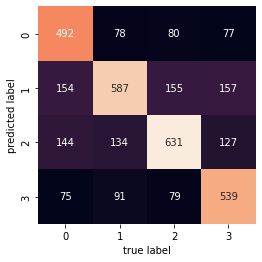

In [36]:
%%time

try:
    SVM, resultados = classificador(x_treino,
                        y_treino,
                        x_teste,
                        y_teste)

except Exception as error:
    logger.warning('Aconteceu algum problema...')
    logger.critical(error)

else:
    logger.info('Ok')
    
finally:
    logger.info('Treino finalizado')

In [37]:
resultados

'              precision    recall  f1-score   support\n\n           1       0.68      0.57      0.62       865\n           2       0.56      0.66      0.60       890\n           3       0.61      0.67      0.64       945\n           4       0.69      0.60      0.64       900\n\n    accuracy                           0.62      3600\n   macro avg       0.63      0.62      0.62      3600\nweighted avg       0.63      0.62      0.63      3600\n'

---

#### Exportando modelo

In [38]:
pkl.dump(SVM, open('modelos/svm_dados_FEM_10_voluntarios_c_semanas_15_sinais_noout.pkl', 'wb'))